1. Here I am trying to implement the [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](http://https://arxiv.org/pdf/1609.05158.pdf) paper on medical chest X-ray images.

2. Here authors have proposed sub-pixel convolution layer which learns an array of upscaling filters to upscale the final Low Resolution feature maps into the High Resolution output. This effectively helps to eliminate bicubic filter in the Super Resolution pipeline with more complex upscaling filters specifically trained for each feature map, whilst also reducing the computational complexity of the overall Super Resolution operation. 

In [108]:
# Import all the necessary libraries

import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

from IPython.display import display

### Define image data generators to load and preprocess the images

In [109]:
crop_size = 512
down_scale_factor = 4
input_size = crop_size // down_scale_factor
batch_size = 8
root_dir = '../input/btdataset/processed_images/'

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 994 files belonging to 3 classes.
Using 796 files for training.
Found 994 files belonging to 3 classes.
Using 198 files for validation.


### Normalize the pixels for training and validation images

In [110]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

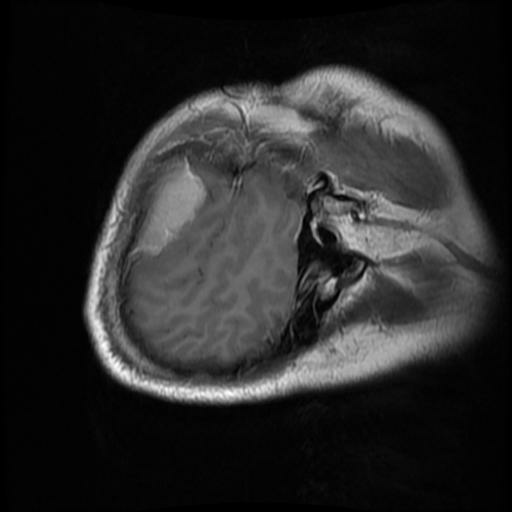

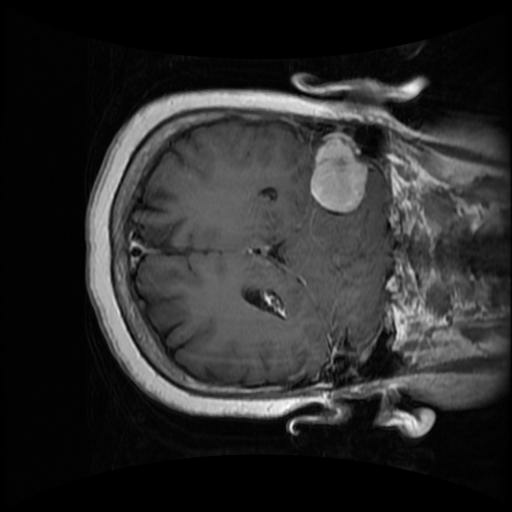

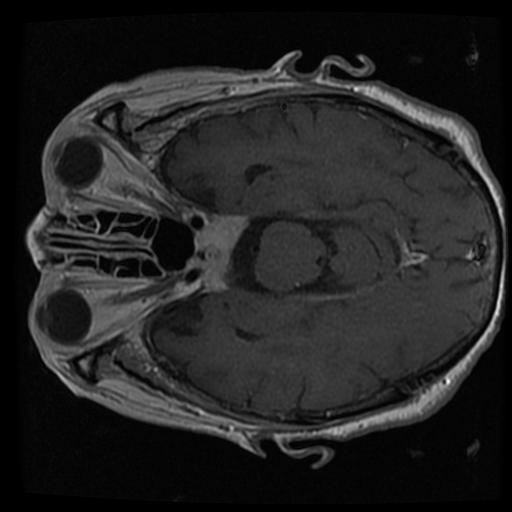

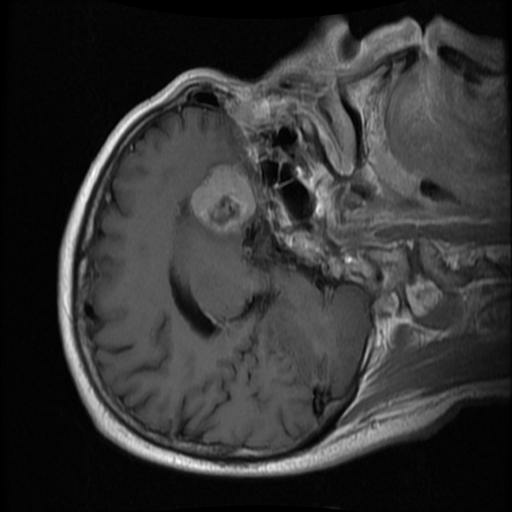

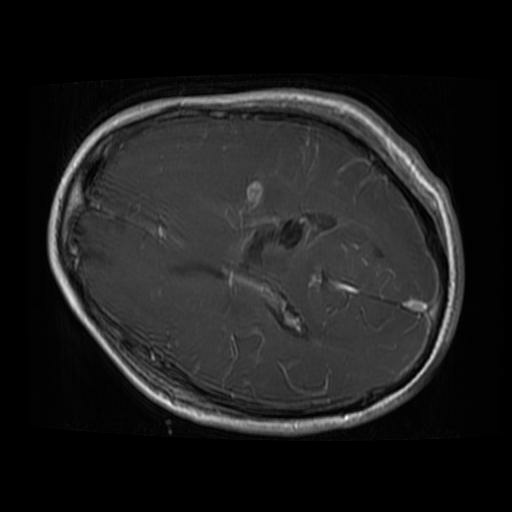

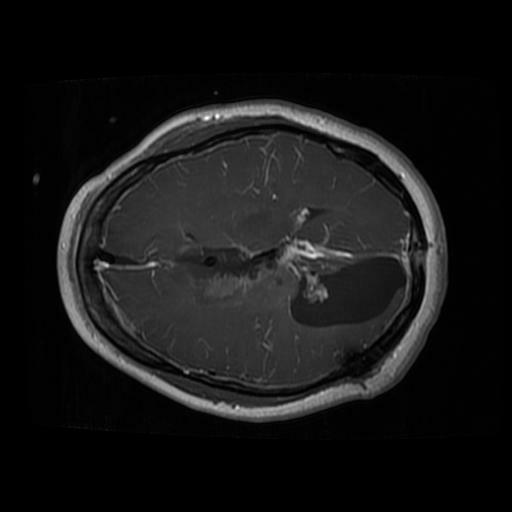

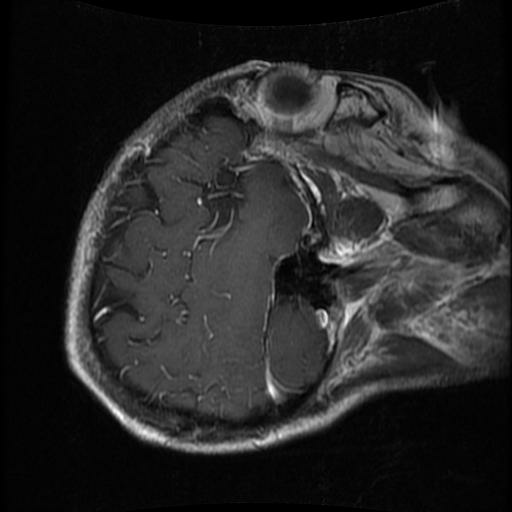

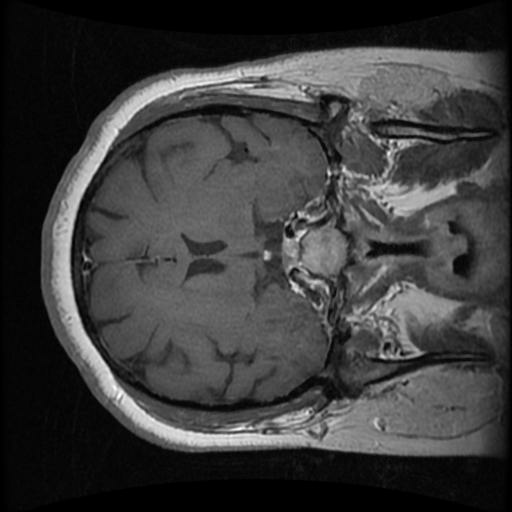

In [111]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

### Here we have prepared a dataset of test image paths that we will use for visual evaluation at the end of this example.

In [112]:
test_path = os.path.join(root_dir, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpeg")
    ]
)


### Here we define functions to process the input images.

1. First, we convert our images from the RGB color space to the YUV colour space.
2. We take input data (low-resolution images), we crop the image, retrieve the y channel (luninance), and resize it. We only consider the luminance channel in the YUV color space because humans are more sensitive to luminance change.
3. For the target data (high-resolution images), we just crop the image and retrieve the y channel.

In [113]:
# Use TF Ops to process.
def process_input(input, input_size, down_scale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, down_scale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, down_scale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

### Visualize input images after processing them. And we will also look into target images

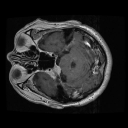

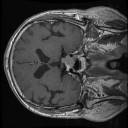

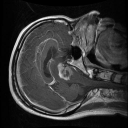

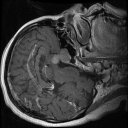

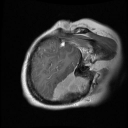

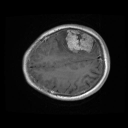

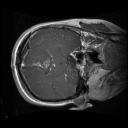

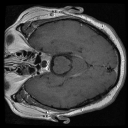

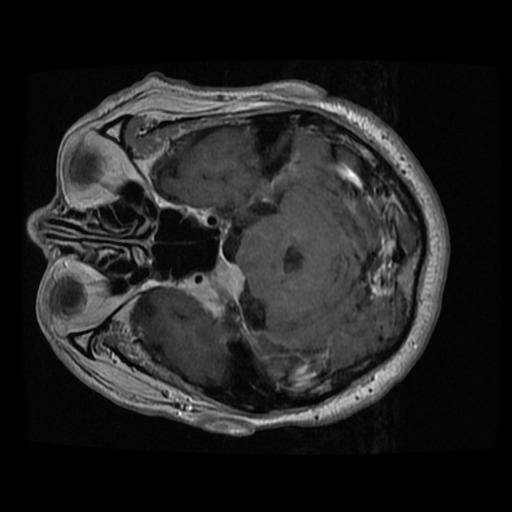

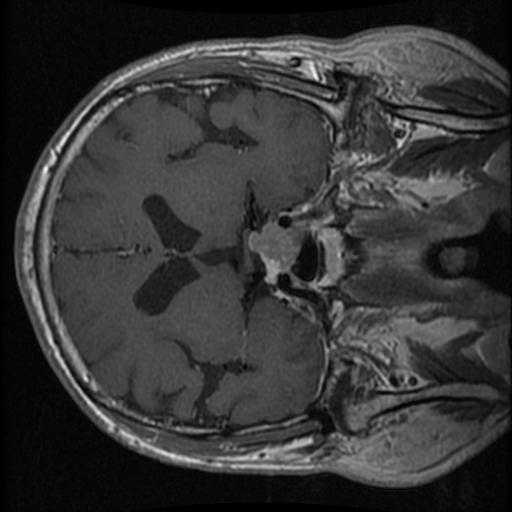

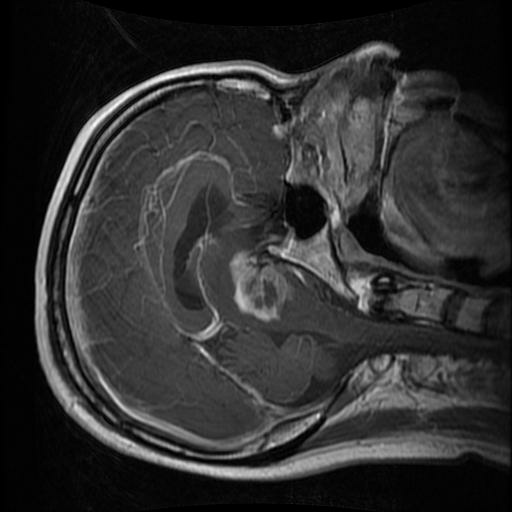

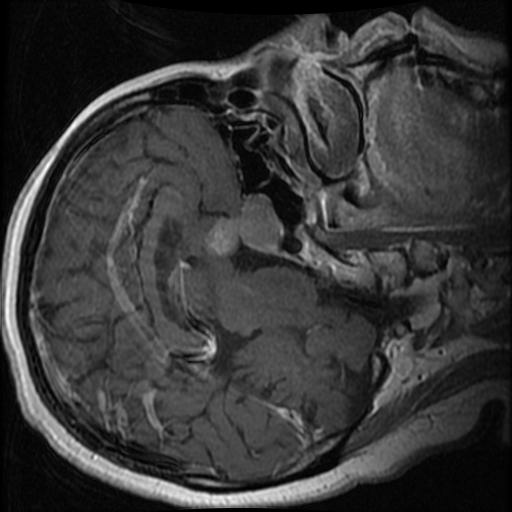

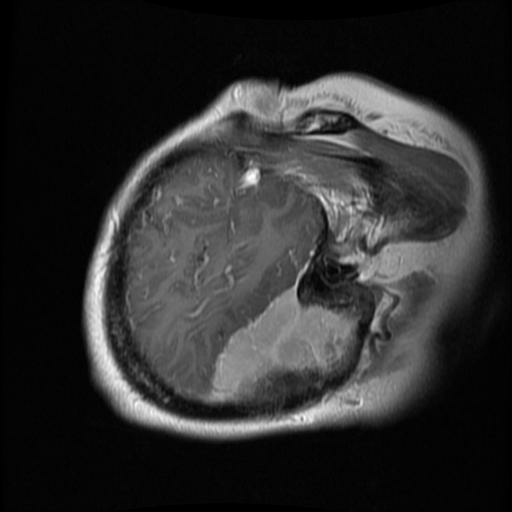

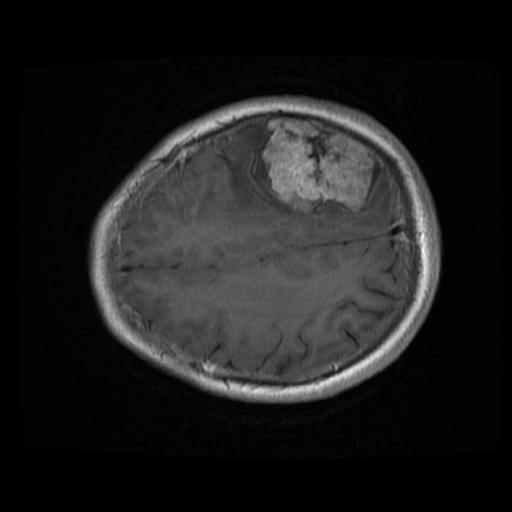

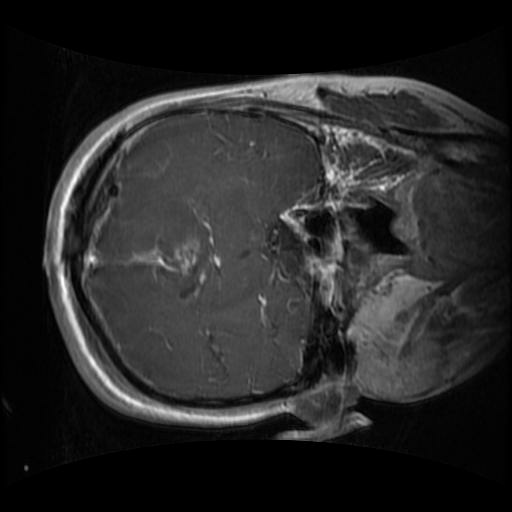

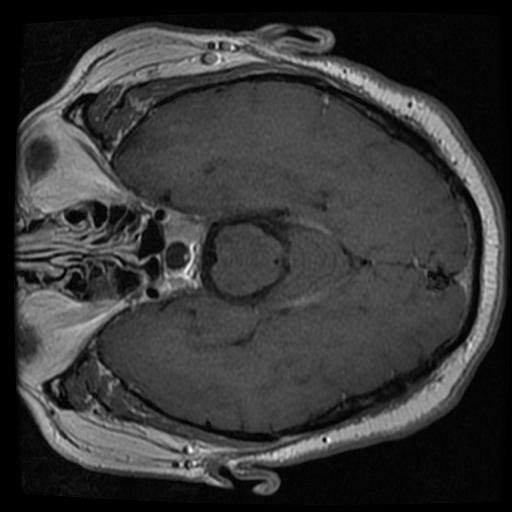

In [114]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

### Define Our CNN Model Architecture

In [115]:
def get_model(down_scale_factor=4, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (down_scale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, down_scale_factor)

    return keras.Model(inputs, outputs)

### Here we have defined some utility functions to monitor our results

1. plot_results to plot an save an image.
2. get_lowres_image to convert an image to its low-resolution version.
3. upscale_image to turn a low-resolution image to a high-resolution version reconstructed by the model. In this function, we use the y channel from the YUV color space as input to the model and then combine the output with the other channels to obtain an RGB image.

In [116]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    plt.show()


def get_lowres_image(img, down_scale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // down_scale_factor, img.size[1] // down_scale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

### Here we have defined callbacks to monitor training

1. The ESPCNCallback object will compute and display the PSNR metric. 
2. This is the main metric we use to evaluate super-resolution performance.

In [117]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), down_scale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []
        
    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [118]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(down_scale_factor=down_scale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, None, None, 16)    4624      
_________________________________________________________________
tf.nn.depth_to_space_7 (TFOp (None, None, None, 1)     0         
Total params: 61,680
Trainable params: 61,680
Non-trainable params: 0
_______________________________________________________

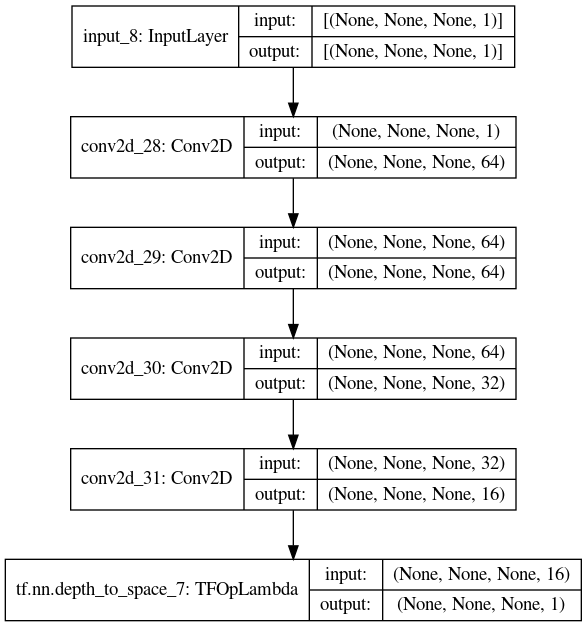

In [119]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/100
100/100 - 9s - loss: 0.0051 - val_loss: 8.8189e-04
Mean PSNR for epoch: 30.44


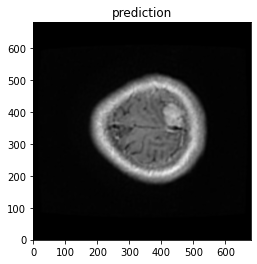

Epoch 2/100
100/100 - 8s - loss: 6.1091e-04 - val_loss: 5.1166e-04
Mean PSNR for epoch: 33.06
Epoch 3/100
100/100 - 8s - loss: 4.8984e-04 - val_loss: 4.6944e-04
Mean PSNR for epoch: 33.36
Epoch 4/100
100/100 - 8s - loss: 4.5062e-04 - val_loss: 4.4536e-04
Mean PSNR for epoch: 33.37
Epoch 5/100
100/100 - 8s - loss: 4.4941e-04 - val_loss: 4.4869e-04
Mean PSNR for epoch: 33.51
Epoch 6/100
100/100 - 8s - loss: 4.1481e-04 - val_loss: 4.1347e-04
Mean PSNR for epoch: 33.80
Epoch 7/100
100/100 - 8s - loss: 3.8588e-04 - val_loss: 3.8713e-04
Mean PSNR for epoch: 34.13
Epoch 8/100
100/100 - 8s - loss: 3.7481e-04 - val_loss: 3.7642e-04
Mean PSNR for epoch: 34.31
Epoch 9/100
100/100 - 8s - loss: 3.8630e-04 - val_loss: 3.7871e-04
Mean PSNR for epoch: 34.36
Epoch 10/100
100/100 - 8s - loss: 3.5744e-04 - val_loss: 3.6282e-04
Mean PSNR for epoch: 34.43
Epoch 11/100
100/100 - 9s - loss: 3.4840e-04 - val_loss: 3.5707e-04
Mean PSNR for epoch: 34.58
Epoch 12/100
100/100 - 8s - loss: 3.5096e-04 - val_loss: 3

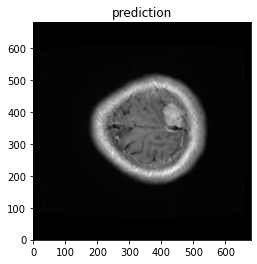

Epoch 22/100
100/100 - 8s - loss: 3.4421e-04 - val_loss: 3.5875e-04
Mean PSNR for epoch: 34.36
Epoch 23/100
100/100 - 8s - loss: 3.2705e-04 - val_loss: 3.3430e-04
Mean PSNR for epoch: 34.55
Epoch 24/100
100/100 - 8s - loss: 3.2399e-04 - val_loss: 3.3694e-04
Mean PSNR for epoch: 34.69
Epoch 25/100
100/100 - 8s - loss: 3.4113e-04 - val_loss: 4.0131e-04
Mean PSNR for epoch: 33.94
Epoch 26/100
100/100 - 8s - loss: 3.6144e-04 - val_loss: 3.3297e-04
Mean PSNR for epoch: 34.85
Epoch 27/100
100/100 - 8s - loss: 3.2092e-04 - val_loss: 3.3401e-04
Mean PSNR for epoch: 34.70
Epoch 28/100
100/100 - 8s - loss: 3.1954e-04 - val_loss: 3.2860e-04
Mean PSNR for epoch: 34.78
Epoch 29/100
100/100 - 8s - loss: 3.1876e-04 - val_loss: 3.2820e-04
Mean PSNR for epoch: 34.81
Epoch 30/100
100/100 - 8s - loss: 3.1879e-04 - val_loss: 3.2890e-04
Mean PSNR for epoch: 34.91
Epoch 31/100
100/100 - 8s - loss: 3.1653e-04 - val_loss: 3.2725e-04
Mean PSNR for epoch: 34.73
Epoch 32/100
100/100 - 8s - loss: 3.1822e-04 - val

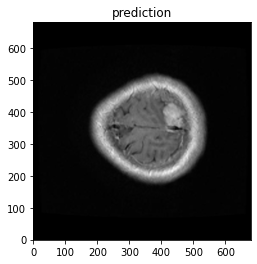

Epoch 42/100
100/100 - 8s - loss: 3.0786e-04 - val_loss: 3.1951e-04
Mean PSNR for epoch: 34.70
Epoch 43/100
100/100 - 8s - loss: 3.0764e-04 - val_loss: 3.1805e-04
Mean PSNR for epoch: 34.81
Epoch 44/100
100/100 - 8s - loss: 3.0893e-04 - val_loss: 3.1663e-04
Mean PSNR for epoch: 34.94
Epoch 45/100
100/100 - 8s - loss: 3.0983e-04 - val_loss: 3.2391e-04
Mean PSNR for epoch: 34.79
Epoch 46/100
100/100 - 8s - loss: 3.0918e-04 - val_loss: 3.1975e-04
Mean PSNR for epoch: 34.81
Epoch 47/100
100/100 - 9s - loss: 3.0713e-04 - val_loss: 3.1463e-04
Mean PSNR for epoch: 34.81
Epoch 48/100
100/100 - 8s - loss: 3.1568e-04 - val_loss: 3.1725e-04
Mean PSNR for epoch: 34.85
Epoch 49/100
100/100 - 8s - loss: 3.1905e-04 - val_loss: 3.1471e-04
Mean PSNR for epoch: 34.94
Epoch 50/100
100/100 - 8s - loss: 3.0389e-04 - val_loss: 3.1437e-04
Mean PSNR for epoch: 35.08
Epoch 51/100
100/100 - 10s - loss: 3.0355e-04 - val_loss: 3.1301e-04
Mean PSNR for epoch: 35.12
Epoch 52/100
100/100 - 8s - loss: 3.0357e-04 - va

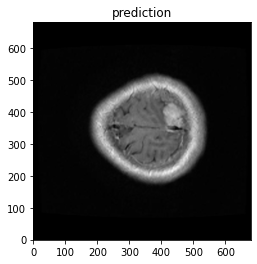

Epoch 62/100
100/100 - 8s - loss: 2.9966e-04 - val_loss: 3.1083e-04
Mean PSNR for epoch: 35.04
Epoch 63/100
100/100 - 8s - loss: 3.0071e-04 - val_loss: 3.1180e-04
Mean PSNR for epoch: 34.97
Epoch 64/100
100/100 - 8s - loss: 3.0314e-04 - val_loss: 3.0924e-04
Mean PSNR for epoch: 34.92
Epoch 65/100
100/100 - 8s - loss: 3.1831e-04 - val_loss: 3.1362e-04
Mean PSNR for epoch: 35.08
Epoch 66/100
100/100 - 9s - loss: 3.0680e-04 - val_loss: 3.1266e-04
Mean PSNR for epoch: 35.04
Epoch 67/100
100/100 - 8s - loss: 2.9878e-04 - val_loss: 3.0745e-04
Mean PSNR for epoch: 35.12
Epoch 68/100
100/100 - 8s - loss: 2.9749e-04 - val_loss: 3.0774e-04
Mean PSNR for epoch: 35.18
Epoch 69/100
100/100 - 8s - loss: 2.9753e-04 - val_loss: 3.0780e-04
Mean PSNR for epoch: 35.06
Epoch 70/100
100/100 - 9s - loss: 3.0183e-04 - val_loss: 3.2071e-04
Mean PSNR for epoch: 35.00
Epoch 71/100
100/100 - 8s - loss: 2.9789e-04 - val_loss: 3.0781e-04
Mean PSNR for epoch: 35.19
Epoch 72/100
100/100 - 8s - loss: 2.9559e-04 - val

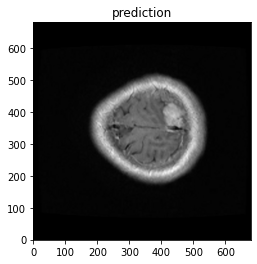

Epoch 82/100
100/100 - 9s - loss: 2.9382e-04 - val_loss: 3.0340e-04
Mean PSNR for epoch: 35.09
Epoch 83/100
100/100 - 8s - loss: 2.9743e-04 - val_loss: 3.0631e-04
Mean PSNR for epoch: 35.20
Epoch 84/100
100/100 - 8s - loss: 2.9543e-04 - val_loss: 3.0396e-04
Mean PSNR for epoch: 35.09
Epoch 85/100
100/100 - 8s - loss: 3.0449e-04 - val_loss: 3.9256e-04
Mean PSNR for epoch: 34.02
Epoch 86/100
100/100 - 8s - loss: 2.9564e-04 - val_loss: 3.0446e-04
Mean PSNR for epoch: 35.20
Epoch 87/100
100/100 - 8s - loss: 2.9403e-04 - val_loss: 3.4033e-04
Mean PSNR for epoch: 34.59
Epoch 88/100
100/100 - 8s - loss: 2.9861e-04 - val_loss: 3.0262e-04
Mean PSNR for epoch: 35.12
Epoch 89/100
100/100 - 8s - loss: 2.9278e-04 - val_loss: 3.0290e-04
Mean PSNR for epoch: 35.25
Epoch 90/100
100/100 - 8s - loss: 2.9145e-04 - val_loss: 3.0292e-04
Mean PSNR for epoch: 35.15
Epoch 91/100
100/100 - 8s - loss: 2.9135e-04 - val_loss: 3.0120e-04
Mean PSNR for epoch: 35.06
Epoch 92/100
100/100 - 8s - loss: 3.0476e-04 - val

In [102]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

### Now we run the model prediction and plot the results

PSNR of low resolution image and high resolution image is 36.8538
PSNR of predict and high resolution is 37.8550
Mean Squared Error of predict and high resolution is 13.4185
SSIM of predict and high resolution is 0.7692


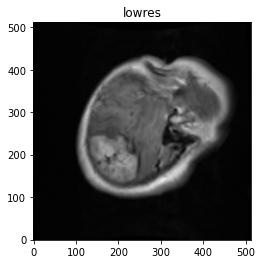

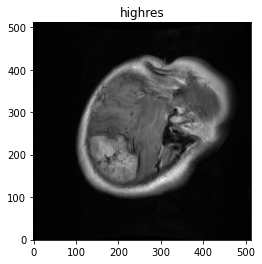

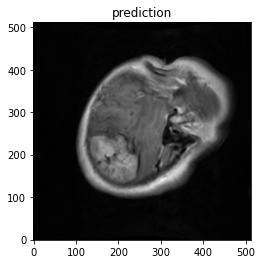

PSNR of low resolution image and high resolution image is 31.9328
PSNR of predict and high resolution is 34.3581
Mean Squared Error of predict and high resolution is 41.6678
SSIM of predict and high resolution is 0.7089


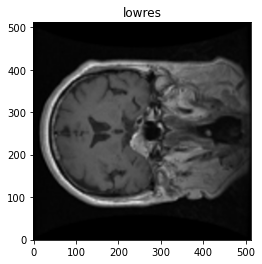

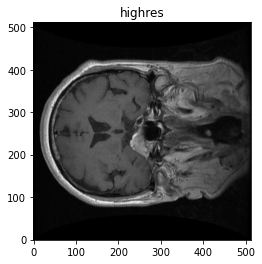

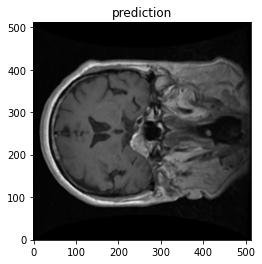

PSNR of low resolution image and high resolution image is 33.1120
PSNR of predict and high resolution is 36.1994
Mean Squared Error of predict and high resolution is 31.7598
SSIM of predict and high resolution is 0.7994


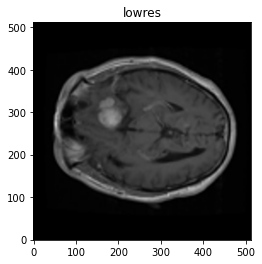

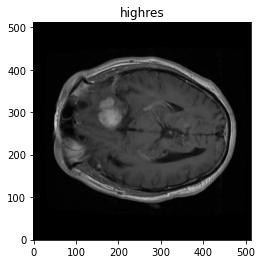

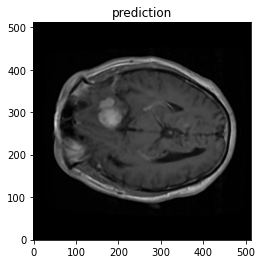

PSNR of low resolution image and high resolution image is 35.2093
PSNR of predict and high resolution is 36.6709
Mean Squared Error of predict and high resolution is 19.5954
SSIM of predict and high resolution is 0.7668


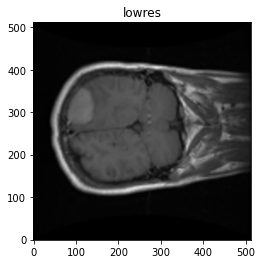

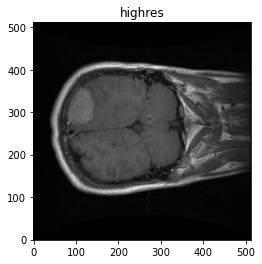

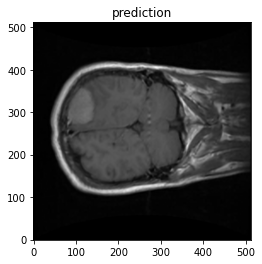

PSNR of low resolution image and high resolution image is 33.2635
PSNR of predict and high resolution is 36.1481
Mean Squared Error of predict and high resolution is 30.6710
SSIM of predict and high resolution is 0.7714


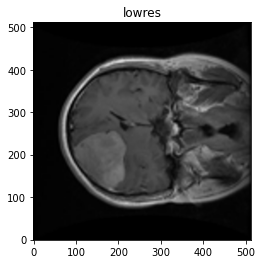

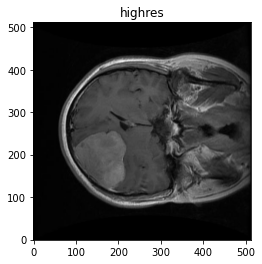

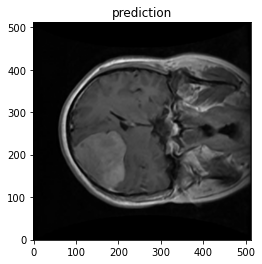

PSNR of low resolution image and high resolution image is 32.6136
PSNR of predict and high resolution is 35.1312
Mean Squared Error of predict and high resolution is 35.6219
SSIM of predict and high resolution is 0.7154


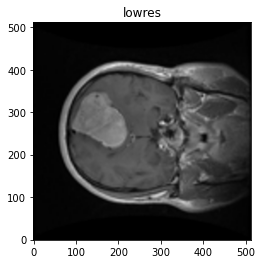

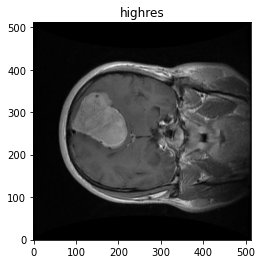

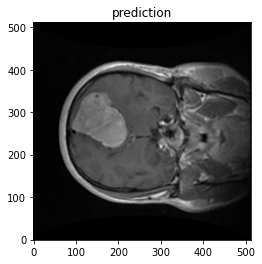

PSNR of low resolution image and high resolution image is 33.3720
PSNR of predict and high resolution is 35.8680
Mean Squared Error of predict and high resolution is 29.9143
SSIM of predict and high resolution is 0.7563


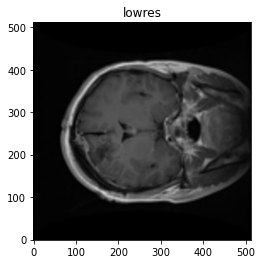

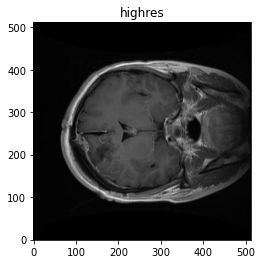

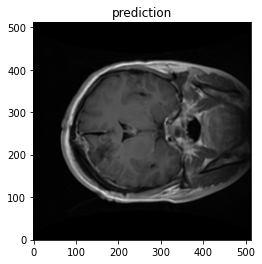

PSNR of low resolution image and high resolution image is 32.0881
PSNR of predict and high resolution is 35.2530
Mean Squared Error of predict and high resolution is 40.2042
SSIM of predict and high resolution is 0.7639


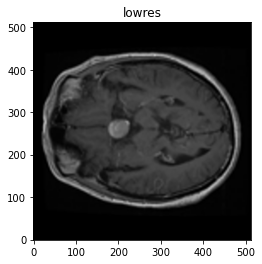

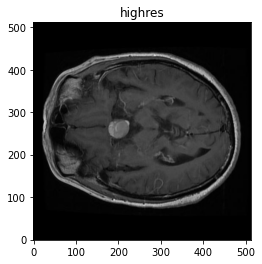

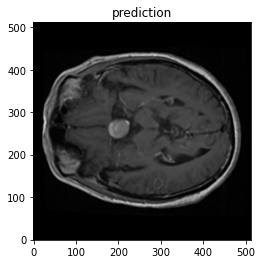

PSNR of low resolution image and high resolution image is 31.7760
PSNR of predict and high resolution is 34.8048
Mean Squared Error of predict and high resolution is 43.1998
SSIM of predict and high resolution is 0.7093


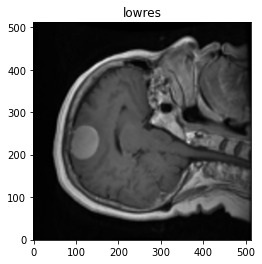

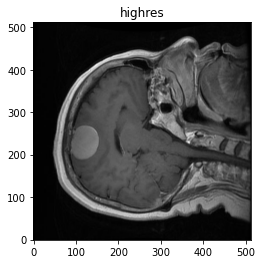

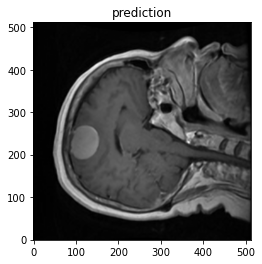

PSNR of low resolution image and high resolution image is 33.6603
PSNR of predict and high resolution is 35.6093
Mean Squared Error of predict and high resolution is 27.9934
SSIM of predict and high resolution is 0.6247


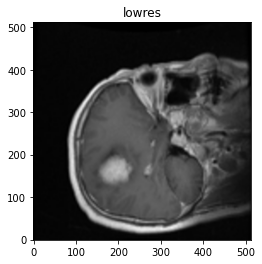

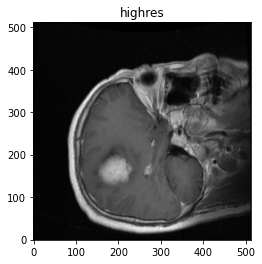

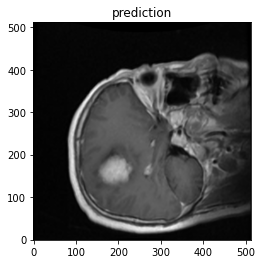

Avg. PSNR of lowres images is 33.3881
Avg. PSNR of reconstructions is 35.7898
Avg. MSE of reconstructions is 31.4046
Avg. SSIM of reconstructions is 0.7385


In [106]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
total_test_ssim = 0.0
total_test_mse = 0.0

for index, test_img_path in enumerate(test_img_paths[35:45]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, down_scale_factor)
    w = lowres_input.size[0] * down_scale_factor
    h = lowres_input.size[1] * down_scale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)
    test_mse = mse(lowres_img_arr, highres_img_arr)
    test_ssim = ssim(lowres_img_arr, highres_img_arr, multichannel=True)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr
    total_test_ssim += test_ssim
    total_test_mse += test_mse

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    print("Mean Squared Error of predict and high resolution is %.4f" % test_mse)
    print("SSIM of predict and high resolution is %.4f" % test_ssim)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))
print("Avg. MSE of reconstructions is %.4f" % (total_test_mse / 10))
print("Avg. SSIM of reconstructions is %.4f" % (total_test_ssim / 10))

In [107]:
%%!

zip -r saved_model.zip /tmp/checkpoint

['  adding: tmp/checkpoint (deflated 48%)']